In [10]:
# Import modules
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

from scipy.stats import spearmanr
from scipy.stats import pearsonr

sns.set_style('white')

plt.rcParams['figure.dpi'] = 100  # Set the resolution of the plot

# Welch's t-test
from scipy.stats import ttest_ind

import warnings
warnings.filterwarnings('ignore')

## Read Data
### No buffer

In [2]:
no_buffer_analysis_path = '../data_no_buffer_analysis_blocks'

no_buffer_imagery = pd.read_csv(os.path.join(no_buffer_analysis_path, 'df_imagery_analysis.csv'))
no_buffer_perception = pd.read_csv(os.path.join(no_buffer_analysis_path, 'df_perception_analysis.csv'))
no_buffer_vviq = pd.read_csv(os.path.join(no_buffer_analysis_path, 'df_vivid_analysis.csv'))
no_buffer_semantic = pd.read_csv(os.path.join(no_buffer_analysis_path, 'df_semantic_analysis.csv'))

### New stimulus

In [3]:
new_stimulus_analysis_path = '../data_new_stimulus_analysis_blocks'

new_stimulus_imagery = pd.read_csv(os.path.join(new_stimulus_analysis_path, 'df_imagery_analysis.csv'))
new_stimulus_perception = pd.read_csv(os.path.join(new_stimulus_analysis_path, 'df_perception_analysis.csv'))
new_stimulus_vviq = pd.read_csv(os.path.join(new_stimulus_analysis_path, 'df_vivid_analysis.csv'))
new_stimulus_semantic = pd.read_csv(os.path.join(new_stimulus_analysis_path, 'df_semantic_analysis.csv'))

### Online

In [4]:
online_analysis_path = '../data_online_analysis_blocks'

online_imagery = pd.read_csv(os.path.join(online_analysis_path, 'df_imagery_analysis.csv'))
online_perception = pd.read_csv(os.path.join(online_analysis_path, 'df_perception_analysis.csv'))
online_vviq = pd.read_csv(os.path.join(online_analysis_path, 'df_vivid_analysis.csv'))


### Combine 3 datasource and imagery and perception

In [5]:
no_buffer_imagery['IorP'] = 'Imagery'
no_buffer_imagery['type'] = 'offline'
no_buffer_perception['IorP'] = 'Perception'
no_buffer_perception['type'] = 'offline'
new_stimulus_imagery['IorP'] = 'Imagery'
new_stimulus_imagery['type'] = 'offline'
new_stimulus_perception['IorP'] = 'Perception'
new_stimulus_perception['type'] = 'offline'
online_imagery['IorP'] = 'Imagery'
online_imagery['type'] = 'online'
online_perception['IorP'] = 'Perception'
online_perception['type'] = 'online'

df_all = pd.concat([no_buffer_imagery, no_buffer_perception, new_stimulus_imagery, new_stimulus_perception, online_imagery, online_perception]).reset_index(drop=True)
df_all.head()

,field,word1,word2,instruction,correctAns,ans_key,ans_corr,ans_rt,vividness_key,vividness_rt,participant,gender,age,education level,handedness,IorP,type,confidence_key,confidence_rt
0,Color,marshmellow,baguette,light,1.0,1.0,1.0,4.082191,4.0,2.318682,L235-K,female,25.0,12.0,right,Imagery,offline,NaN,NaN
1,Color,strawberry,fig,light,1.0,1.0,1.0,3.781748,1.0,0.078277,L235-K,female,25.0,12.0,right,Imagery,offline,NaN,NaN
2,Color,redwine,espresso,dark,2.0,2.0,1.0,1.778935,4.0,1.091721,L235-K,female,25.0,12.0,right,Imagery,offline,NaN,NaN
3,Color,pumpkin,banana,dark,1.0,1.0,1.0,2.233298,3.0,0.968295,L235-K,female,25.0,12.0,right,Imagery,offline,NaN,NaN
4,Color,guacamole,pomogranate,dark,2.0,2.0,1.0,4.418069,3.0,0.665471,L235-K,female,25.0,12.0,right,Imagery,offline,NaN,NaN


In [6]:
df_participant_info = df_all.groupby(['participant'])['gender', 'age', 'type', 'handedness'].max().reset_index()
df_participant_info.gender = df_participant_info.gender.str.lower()
# df_participant_info.to_csv('df_participant_info.csv', index=False)
df_participant_info.head()

,participant,gender,age,type,handedness
0,L127-H,male,20.0,offline,right
1,L128-H,female,19.0,offline,right
2,L129-O,male,34.0,online,right
3,L130-H,male,22.0,offline,right
4,L130-O,male,27.0,online,Right


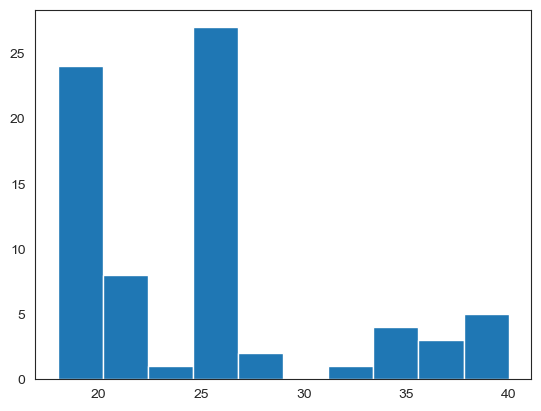

In [11]:
plt.hist(df_participant_info['age'])
plt.show()

In [12]:
df_participant_info.age.describe()

count    75.000000
mean     24.946667
std       5.876875
min      18.000000
25%      20.000000
50%      25.000000
75%      25.000000
max      40.000000
Name: age, dtype: float64

In [13]:
df_participant_info.type.value_counts()

offline    49
online     26
Name: type, dtype: int64

In [14]:
# normalize ans_rt and vividness_rt for each individual, combining imagery and perception
df_all['ans_rt_norm'] = df_all.groupby(['participant'])['ans_rt'].apply(lambda x: (x - x.mean()) / x.std())
df_all['vividness_rt_norm'] = df_all.groupby(['participant'])['vividness_rt'].apply(lambda x: (x - x.mean()) / x.std())
df_all['confidence_rt_norm'] = df_all.groupby(['participant'])['confidence_rt'].apply(lambda x: (x - x.mean()) / x.std())

In [16]:
df_all['participant_id'] = df_all['participant'].apply(lambda x: int(re.findall(r'\d+', x)[0]))
df_all['participant_id'] = df_all['participant_id'].astype(int)
df_all['participant_id'] = df_all['participant_id'] - np.min(df_all['participant_id']) + 1
df_all.to_csv('df_all.csv', index=False)

In [17]:
df_tmp = df_all[['participant', 'field', 'IorP', 'ans_corr', 'vividness_key', 'ans_rt_norm', 'vividness_rt_norm', 'ans_rt', 'vividness_rt','confidence_key', 'confidence_rt', 'confidence_rt_norm']]
df_agg = df_tmp.groupby(['participant', 'IorP', 'field']).mean().reset_index()
df_agg.to_csv('df_agg.csv', index=False)

## VVIQ and performance

In [18]:
df_agg.head()

,participant,IorP,field,ans_corr,vividness_key,ans_rt_norm,vividness_rt_norm,ans_rt,vividness_rt,confidence_key,confidence_rt,confidence_rt_norm
0,L127-H,Imagery,Color,1.000000,3.888889,-0.089344,0.685701,1.358138,1.405026,NaN,NaN,NaN
1,L127-H,Imagery,Face,0.722222,3.000000,0.866611,0.280553,1.993851,1.256204,NaN,NaN,NaN
2,L127-H,Imagery,Letter,1.000000,3.722222,-0.488657,-0.101244,1.092593,1.115960,NaN,NaN,NaN
3,L127-H,Imagery,Map,1.000000,3.166667,-0.015587,-0.337043,1.407186,1.029345,NaN,NaN,NaN
4,L127-H,Imagery,Shape,1.000000,3.722222,-0.218949,-0.527967,1.271950,0.959214,NaN,NaN,NaN


In [19]:
vviq = pd.concat([no_buffer_vviq, new_stimulus_vviq, online_vviq]).reset_index(drop=True)
vviq_sum = vviq.groupby(['participant'])['ans_key'].sum().reset_index()
vviq_sum.columns = ['participant', 'vviq_sum']

df_agg_vviq = pd.merge(df_agg, vviq_sum, on='participant', how='left')
df_agg_vviq.head()

df_agg_vviq = df_agg.copy()
df_agg_vviq = df_agg_vviq[df_agg_vviq['IorP'] == 'Imagery']
df_agg_vviq = pd.merge(df_agg_vviq, vviq_sum, on='participant', how='left')

In [20]:
df_agg_vviq.head()

,participant,IorP,field,ans_corr,vividness_key,ans_rt_norm,vividness_rt_norm,ans_rt,vividness_rt,confidence_key,confidence_rt,confidence_rt_norm,vviq_sum
0,L127-H,Imagery,Color,1.000000,3.888889,-0.089344,0.685701,1.358138,1.405026,NaN,NaN,NaN,72.0
1,L127-H,Imagery,Face,0.722222,3.000000,0.866611,0.280553,1.993851,1.256204,NaN,NaN,NaN,72.0
2,L127-H,Imagery,Letter,1.000000,3.722222,-0.488657,-0.101244,1.092593,1.115960,NaN,NaN,NaN,72.0
3,L127-H,Imagery,Map,1.000000,3.166667,-0.015587,-0.337043,1.407186,1.029345,NaN,NaN,NaN,72.0
4,L127-H,Imagery,Shape,1.000000,3.722222,-0.218949,-0.527967,1.271950,0.959214,NaN,NaN,NaN,72.0


In [21]:
vviq_performance_overall = vviq_performance = df_agg_vviq.groupby(['participant']).agg({'vviq_sum': 'max', 'ans_corr': 'mean', 'ans_rt': 'mean'}).reset_index()
vviq_performance_overall.head()

,participant,vviq_sum,ans_corr,ans_rt
0,L127-H,72.0,0.944444,1.424743
1,L128-H,60.0,0.900000,1.362684
2,L129-O,49.0,0.822222,1.225182
3,L130-H,72.0,0.877778,2.076891
4,L130-O,59.0,0.911111,0.918281


In [22]:
vviq_performance = df_agg_vviq.groupby(['participant', 'field']).agg({'vviq_sum': 'max', 'ans_corr': 'mean', 'ans_rt': 'mean'}).reset_index()
vviq_performance.head()

,participant,field,vviq_sum,ans_corr,ans_rt
0,L127-H,Color,72.0,1.000000,1.358138
1,L127-H,Face,72.0,0.722222,1.993851
2,L127-H,Letter,72.0,1.000000,1.092593
3,L127-H,Map,72.0,1.000000,1.407186
4,L127-H,Shape,72.0,1.000000,1.271950


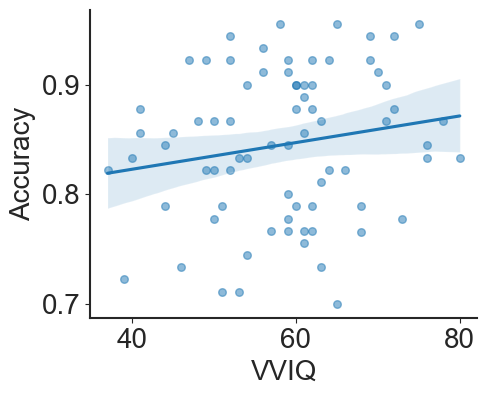

In [23]:
fig, ax = plt.subplots(figsize=(5, 4))
sns.regplot(x='vviq_sum', y='ans_corr', data=vviq_performance_overall, scatter_kws={'alpha':0.5, 's':30})
# plt.title('Averge Vividness vs VVIQ')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

# axis label size
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('VVIQ', fontsize=20)
ax.set_ylabel('Accuracy', fontsize=20)

ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

In [24]:
print(spearmanr(vviq_performance_overall['vviq_sum'], vviq_performance_overall['ans_corr']))

SpearmanrResult(correlation=0.15100208079105046, pvalue=0.19594829626779772)


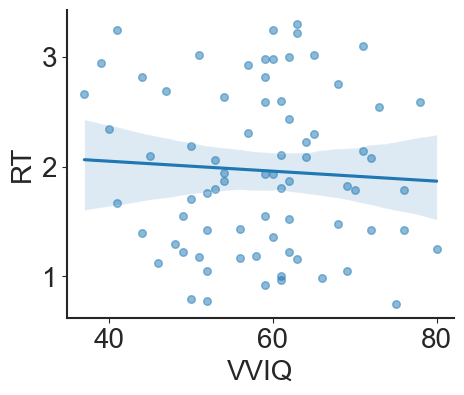

In [25]:
fig, ax = plt.subplots(figsize=(5, 4))
sns.regplot(x='vviq_sum', y='ans_rt', data=vviq_performance_overall, scatter_kws={'alpha':0.5, 's':30})
# plt.title('Averge Vividness vs VVIQ')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

# axis label size
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('VVIQ', fontsize=20)
ax.set_ylabel('RT', fontsize=20)

ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

In [26]:
print(pearsonr(vviq_performance_overall['vviq_sum'], vviq_performance_overall['ans_rt']))

PearsonRResult(statistic=-0.06133789040395209, pvalue=0.6011326871335639)


In [27]:
from scipy.stats import pearsonr
color_palette = ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD']

Color VVIQ vs Accuracy (r=0.1358, p=0.2455)
Face VVIQ vs Accuracy (r=0.2448, p=0.0343)
Letter VVIQ vs Accuracy (r=-0.0253, p=0.8295)
Map VVIQ vs Accuracy (r=0.0588, p=0.6165)
Shape VVIQ vs Accuracy (r=0.0347, p=0.7676)


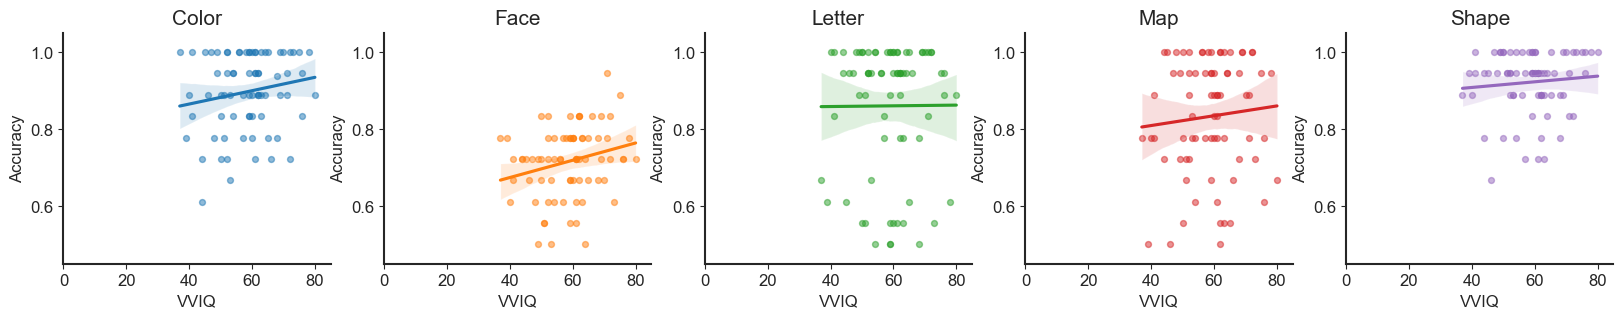

In [28]:
fig, ax = plt.subplots(1, 5, figsize=(20, 3))
for i, field in enumerate(vviq_performance['field'].unique()):
    vviq_performance_field = vviq_performance[vviq_performance['field'] == field]
    # calculate the pearson correlation
    corr_vviq_acc, p_value_vviq_acc = spearmanr(vviq_performance_field['vviq_sum'], vviq_performance_field['ans_corr'])
    print(f'{field} VVIQ vs Accuracy (r={corr_vviq_acc:.4f}, p={p_value_vviq_acc:.4f})')
    sns.regplot(x='vviq_sum', y='ans_corr', data=vviq_performance_field, ax=ax[i], color=color_palette[i], scatter_kws={'alpha':0.5, 's':18})
    ax[i].set_title(field, fontsize=15)
    ax[i].set_xlabel('VVIQ', fontsize=12)
    ax[i].set_ylabel('Accuracy', fontsize=12)
    ax[i].set_xlim(0, 85)
    ax[i].set_ylim(0.45, 1.05)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['left'].set_linewidth(1.5)
    ax[i].spines['bottom'].set_linewidth(1.5)

    ax[i].yaxis.set_ticks_position('left')
    ax[i].xaxis.set_ticks_position('bottom')
    ax[i].tick_params(axis='both', which='major', labelsize=12)

Color VVIQ vs RT (r=-0.1616, p=0.1661)
Face VVIQ vs RT (r=-0.0150, p=0.8987)
Letter VVIQ vs RT (r=0.0164, p=0.8890)
Map VVIQ vs RT (r=0.0170, p=0.8850)
Shape VVIQ vs RT (r=-0.1504, p=0.1977)


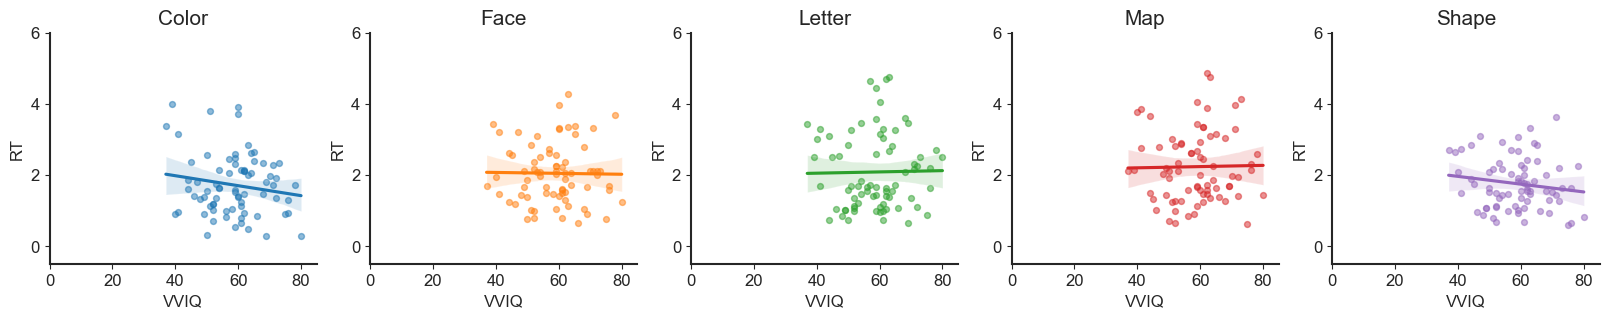

In [29]:
fig, ax = plt.subplots(1, 5, figsize=(20, 3))
for i, field in enumerate(vviq_performance['field'].unique()):
    vviq_performance_field = vviq_performance[vviq_performance['field'] == field]
    # calculate the pearson correlation
    corr_vviq_acc, p_value_vviq_acc = pearsonr(vviq_performance_field['vviq_sum'], vviq_performance_field['ans_rt'])
    print(f'{field} VVIQ vs RT (r={corr_vviq_acc:.4f}, p={p_value_vviq_acc:.4f})')
    sns.regplot(x='vviq_sum', y='ans_rt', data=vviq_performance_field, ax=ax[i], color=color_palette[i], scatter_kws={'alpha':0.5, 's':18})
    ax[i].set_title(field, fontsize=15)
    ax[i].set_xlabel('VVIQ', fontsize=12)
    ax[i].set_ylabel('RT', fontsize=12)
    ax[i].set_xlim(0, 85)
    ax[i].set_ylim(-0.5, 6)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['left'].set_linewidth(1.5)
    ax[i].spines['bottom'].set_linewidth(1.5)

    ax[i].yaxis.set_ticks_position('left')
    ax[i].xaxis.set_ticks_position('bottom')
    ax[i].tick_params(axis='both', which='major', labelsize=12)

## VVIQ correlation with  vividness


In [30]:
df_agg_vviq.head()

,participant,IorP,field,ans_corr,vividness_key,ans_rt_norm,vividness_rt_norm,ans_rt,vividness_rt,confidence_key,confidence_rt,confidence_rt_norm,vviq_sum
0,L127-H,Imagery,Color,1.000000,3.888889,-0.089344,0.685701,1.358138,1.405026,NaN,NaN,NaN,72.0
1,L127-H,Imagery,Face,0.722222,3.000000,0.866611,0.280553,1.993851,1.256204,NaN,NaN,NaN,72.0
2,L127-H,Imagery,Letter,1.000000,3.722222,-0.488657,-0.101244,1.092593,1.115960,NaN,NaN,NaN,72.0
3,L127-H,Imagery,Map,1.000000,3.166667,-0.015587,-0.337043,1.407186,1.029345,NaN,NaN,NaN,72.0
4,L127-H,Imagery,Shape,1.000000,3.722222,-0.218949,-0.527967,1.271950,0.959214,NaN,NaN,NaN,72.0


In [31]:
vividvsvviq = df_agg_vviq.groupby('participant')['vividness_key', 'vviq_sum'].mean().reset_index()
vividvsvviq.head()

,participant,vividness_key,vviq_sum
0,L127-H,3.500000,72.0
1,L128-H,3.588889,60.0
2,L129-O,3.888889,49.0
3,L130-H,3.666667,72.0
4,L130-O,2.655556,59.0


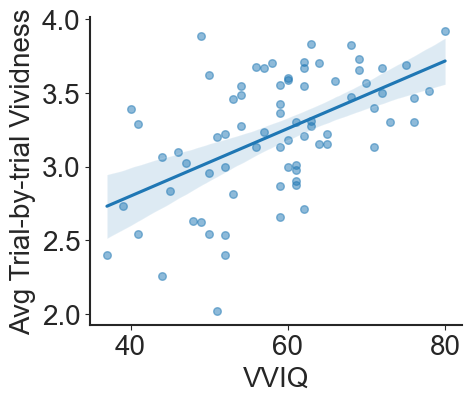

In [32]:
fig, ax = plt.subplots(figsize=(4.8, 4))
sns.regplot(x='vviq_sum', y='vividness_key', data=vividvsvviq, scatter_kws={'alpha':0.5, 's':30})
plt.xlabel('VVIQ')
plt.ylabel('Average Vividness')
# plt.title('Averge Vividness vs VVIQ')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

# axis label size
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('VVIQ', fontsize=20)
ax.set_ylabel('Avg Trial-by-trial Vividness', fontsize=20)

ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

In [33]:
# correlation between vividness and vviq
print(f'Correlation between vividness and VVIQ: {spearmanr(vividvsvviq["vviq_sum"], vividvsvviq["vividness_key"])}')


Correlation between vividness and VVIQ: SpearmanrResult(correlation=0.5159723218886483, pvalue=2.159840209572627e-06)


In [34]:
vvid_domain = df_agg_vviq.groupby(['participant', 'field'])['vividness_key', 'vviq_sum'].mean().reset_index()
vvid_domain.head()

,participant,field,vividness_key,vviq_sum
0,L127-H,Color,3.888889,72.0
1,L127-H,Face,3.000000,72.0
2,L127-H,Letter,3.722222,72.0
3,L127-H,Map,3.166667,72.0
4,L127-H,Shape,3.722222,72.0


Color VVIQ vs Vividness (r=0.4773, p=0.0000)
Face VVIQ vs Vividness (r=0.4297, p=0.0001)
Letter VVIQ vs Vividness (r=0.2797, p=0.0151)
Map VVIQ vs Vividness (r=0.1902, p=0.1021)
Shape VVIQ vs Vividness (r=0.4354, p=0.0001)


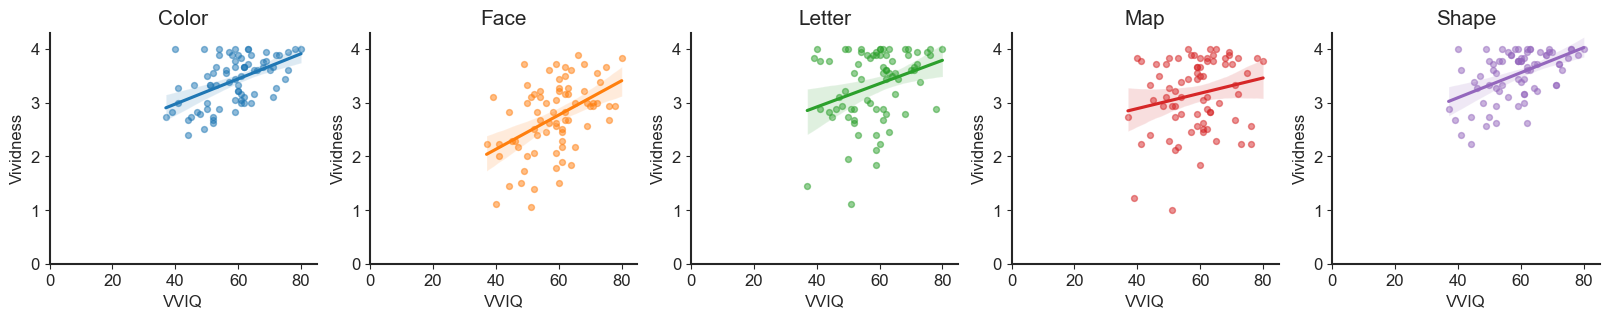

In [35]:
fig, ax = plt.subplots(1, 5, figsize=(20, 3))
for i, field in enumerate(vvid_domain['field'].unique()):
    vvid_domain_field = vvid_domain[vvid_domain['field'] == field]
    # calculate the pearson correlation
    corr_vviq_vividness, p_value_vviq_vividness = spearmanr(vvid_domain_field['vviq_sum'], vvid_domain_field['vividness_key'])
    print(f'{field} VVIQ vs Vividness (r={corr_vviq_vividness:.4f}, p={p_value_vviq_vividness:.4f})')
    sns.regplot(x='vviq_sum', y='vividness_key', data=vvid_domain_field, ax=ax[i], color=color_palette[i], scatter_kws={'alpha':0.5, 's':18})
    ax[i].set_title(field, fontsize=15)
    ax[i].set_xlabel('VVIQ', fontsize=12)
    ax[i].set_ylabel('Vividness', fontsize=12)
    ax[i].set_xlim(0, 85)
    ax[i].set_ylim(0, 4.3)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['left'].set_linewidth(1.5)
    ax[i].spines['bottom'].set_linewidth(1.5)

    ax[i].yaxis.set_ticks_position('left')
    ax[i].xaxis.set_ticks_position('bottom')
    ax[i].tick_params(axis='both', which='major', labelsize=12)

## Vividness and performance

In [36]:
# color_palette = ['#1F77B4', '#FF7F0E', '#2CA02C', '#D62728', '#9467BD']

# i = 0
# for field in df_agg_vviq['field'].unique():
#     print(field)
#     df_agg_vviq_field = df_agg_vviq[df_agg_vviq['field'] == field]
#     # two figures, one for accuracy, one for RT side by side
#     fig, ax = plt.subplots(1, 2, figsize=(12, 3.5))
#     corr_vviq_anscorr, p_value_anscorr = spearmanr(df_agg_vviq_field['vividness_key'], df_agg_vviq_field['ans_corr'])
#     corr_vviq_ansrt, p_value_ansrt = spearmanr(df_agg_vviq_field['vividness_key'], df_agg_vviq_field['ans_rt'])
#     sns.regplot(x='vividness_key', y='ans_corr', data=df_agg_vviq_field, ax=ax[0], scatter_kws={'alpha':0.5, 's':18}, color=color_palette[i])
#     sns.regplot(x='vividness_key', y='ans_rt', data=df_agg_vviq_field, ax=ax[1], scatter_kws={'alpha':0.5, 's':18}, color=color_palette[i])
#     print(f'{field} Accuracy vs vividness (r={corr_vviq_anscorr:.4f}, p={p_value_anscorr:.4f})')
#     ax[0].set_title('Accuracy vs vividness')
#     print(f'{field} RT vs vividness (r={corr_vviq_ansrt:.4f}, p={p_value_ansrt:.4f})')
#     ax[1].set_title('RT vs vividness')
#     ax[0].set_xlabel('Vividness')
#     ax[1].set_xlabel('Vividness')
#     ax[0].set_ylabel('Accuracy')
#     ax[1].set_ylabel('RT')
    
#     ax[0].tick_params(axis='both', which='major', labelsize=12)
#     ax[1].tick_params(axis='both', which='major', labelsize=12)
    
#     ax[0].yaxis.set_ticks_position('left')
#     ax[0].xaxis.set_ticks_position('bottom')
#     ax[1].yaxis.set_ticks_position('left')
#     ax[1].xaxis.set_ticks_position('bottom')
    
#     # remove top and right
#     for loc in ['top', 'right']:
#         ax[0].spines[loc].set_visible(False)
#         ax[1].spines[loc].set_visible(False)

#     # fig.suptitle(field, fontsize=15)
#     i = i + 1

In [37]:
vivid_performance_overall = df_agg_vviq.groupby(['participant']).agg({'vividness_key': 'mean', 'ans_corr': 'mean', 'ans_rt': 'mean'}).reset_index()
vivid_performance_overall.head()

,participant,vividness_key,ans_corr,ans_rt
0,L127-H,3.500000,0.944444,1.424743
1,L128-H,3.588889,0.900000,1.362684
2,L129-O,3.888889,0.822222,1.225182
3,L130-H,3.666667,0.877778,2.076891
4,L130-O,2.655556,0.911111,0.918281


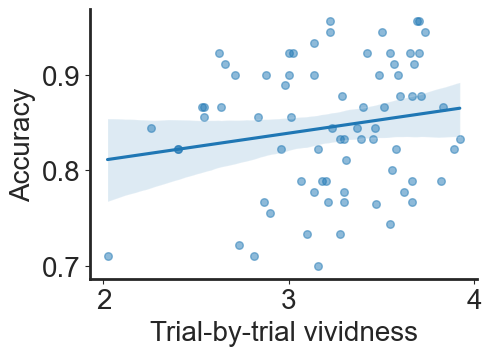

In [38]:
fig, ax = plt.subplots(figsize=(5, 3.5))
sns.regplot(x='vividness_key', y='ans_corr', data=vivid_performance_overall, scatter_kws={'alpha':0.5, 's':30})
# plt.title('Averge Vividness vs VVIQ')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)


# axis label size
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('Trial-by-trial vividness', fontsize=20)
ax.set_ylabel('Accuracy', fontsize=20)

ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

In [39]:
print(spearmanr(vivid_performance_overall['vividness_key'], vivid_performance_overall['ans_corr']))

SpearmanrResult(correlation=0.17050912098625134, pvalue=0.14358109164232927)


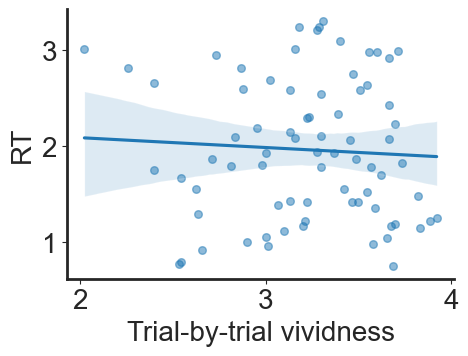

In [40]:
fig, ax = plt.subplots(figsize=(5, 3.5))
sns.regplot(x='vividness_key', y='ans_rt', data=vivid_performance_overall, scatter_kws={'alpha':0.5, 's':30})
# plt.title('Averge Vividness vs VVIQ')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)

# axis label size
ax.tick_params(axis='both', which='major', labelsize=20)
ax.set_xlabel('Trial-by-trial vividness', fontsize=20)
ax.set_ylabel('RT', fontsize=20)

ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

In [41]:
print(spearmanr(vivid_performance_overall['vividness_key'], vivid_performance_overall['ans_rt']))

SpearmanrResult(correlation=-0.0464490983489681, pvalue=0.6923128201294197)


In [42]:
vivid_performance = df_agg_vviq.groupby(['participant', 'field']).agg({'vividness_key': 'mean', 'ans_corr': 'mean', 'ans_rt': 'mean'}).reset_index()
vivid_performance.head()

,participant,field,vividness_key,ans_corr,ans_rt
0,L127-H,Color,3.888889,1.000000,1.358138
1,L127-H,Face,3.000000,0.722222,1.993851
2,L127-H,Letter,3.722222,1.000000,1.092593
3,L127-H,Map,3.166667,1.000000,1.407186
4,L127-H,Shape,3.722222,1.000000,1.271950


Color TBT Vividness vs Accuracy (r=0.2854, p=0.0131)
Face TBT Vividness vs Accuracy (r=0.3940, p=0.0005)
Letter TBT Vividness vs Accuracy (r=0.4179, p=0.0002)
Map TBT Vividness vs Accuracy (r=0.4255, p=0.0001)
Shape TBT Vividness vs Accuracy (r=0.0591, p=0.6147)


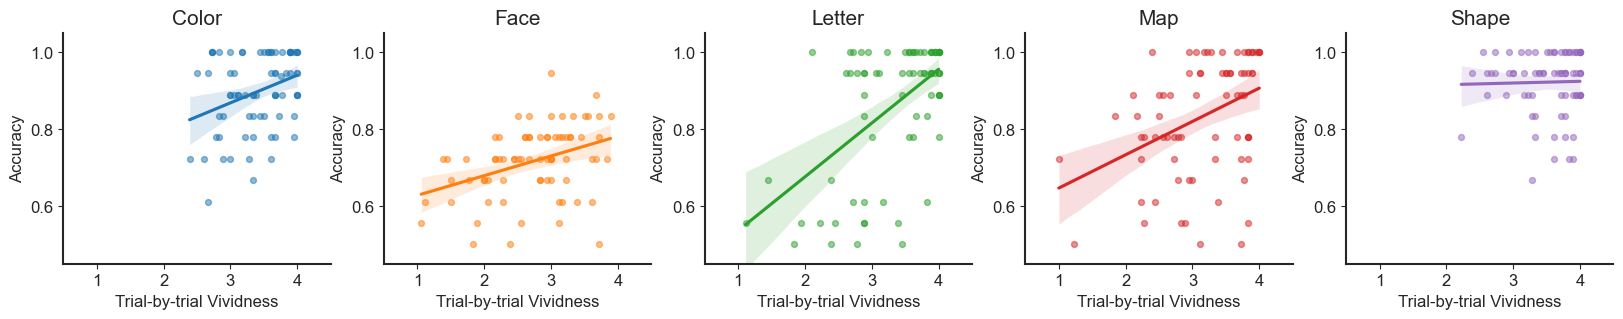

In [43]:
fig, ax = plt.subplots(1, 5, figsize=(20, 3))
for i, field in enumerate(vivid_performance['field'].unique()):
    vivid_performance_field = vivid_performance[vivid_performance['field'] == field]
    # calculate the pearson correlation
    corr_vviq_acc, p_value_vviq_acc = spearmanr(vivid_performance_field['vividness_key'], vivid_performance_field['ans_corr'])
    print(f'{field} TBT Vividness vs Accuracy (r={corr_vviq_acc:.4f}, p={p_value_vviq_acc:.4f})')
    sns.regplot(x='vividness_key', y='ans_corr', data=vivid_performance_field, ax=ax[i], color=color_palette[i], scatter_kws={'alpha':0.5, 's':18})
    ax[i].set_title(field, fontsize=15)
    ax[i].set_xlabel('Trial-by-trial Vividness', fontsize=12)
    ax[i].set_ylabel('Accuracy', fontsize=12)
    ax[i].set_xlim(0.5, 4.5)
    ax[i].set_ylim(0.45, 1.05)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['left'].set_linewidth(1.5)
    ax[i].spines['bottom'].set_linewidth(1.5)

    ax[i].yaxis.set_ticks_position('left')
    ax[i].xaxis.set_ticks_position('bottom')
    ax[i].tick_params(axis='both', which='major', labelsize=12)

Color TBT Vividness vs RT (r=-0.1064, p=0.3636)
Face TBT Vividness vs RT (r=-0.0966, p=0.4098)
Letter TBT Vividness vs RT (r=-0.2534, p=0.0283)
Map TBT Vividness vs RT (r=-0.1778, p=0.1269)
Shape TBT Vividness vs RT (r=-0.0757, p=0.5186)


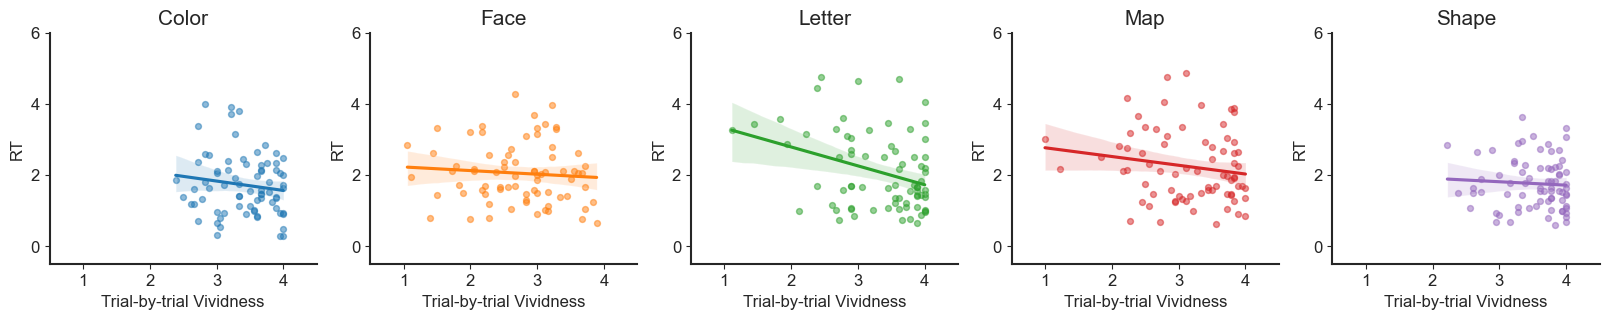

In [44]:
fig, ax = plt.subplots(1, 5, figsize=(20, 3))
for i, field in enumerate(vivid_performance['field'].unique()):
    vivid_performance_field = vivid_performance[vivid_performance['field'] == field]
    # calculate the pearson correlation
    corr_vviq_ansrt, p_value_vviq_ansrt = spearmanr(vivid_performance_field['vividness_key'], vivid_performance_field['ans_rt'])
    print(f'{field} TBT Vividness vs RT (r={corr_vviq_ansrt:.4f}, p={p_value_vviq_ansrt:.4f})')
    sns.regplot(x='vividness_key', y='ans_rt', data=vivid_performance_field, ax=ax[i], color=color_palette[i], scatter_kws={'alpha':0.5, 's':18})
    ax[i].set_title(field, fontsize=15)
    ax[i].set_xlabel('Trial-by-trial Vividness', fontsize=12)
    ax[i].set_ylabel('RT', fontsize=12)
    ax[i].set_xlim(0.5, 4.5)
    ax[i].set_ylim(-0.5, 6)
    ax[i].spines['right'].set_visible(False)
    ax[i].spines['top'].set_visible(False)
    ax[i].spines['left'].set_linewidth(1.5)
    ax[i].spines['bottom'].set_linewidth(1.5)
    
    ax[i].yaxis.set_ticks_position('left')
    ax[i].xaxis.set_ticks_position('bottom')
    ax[i].tick_params(axis='both', which='major', labelsize=12)
    